Import Libraries

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pyspark.sql.functions import *
from pyspark.sql.types import *

import calendar
import csv
import os
from io import StringIO

Define Unziping files Function

In [0]:
def unzipper(file_name=None):
    if not file_name:
        # Ask the user to provide the name of the file to unzip.
        file_name = input("Kindly Enter the name of the file you want unzipped (including file type): ")

    # Construct full source path
    file_name= file_name
    file_root = '/FileStore/tables'
    destination_path = 'dbfs:/FileStore/tables/'

    source_path = f"{file_root}/{file_name}"
    # Copy zip file from source to destination
    dbutils.fs.cp(source_path, 'file:/tmp/')
    
    # Unzip the file and get names
    unzip_cmd = f'unzip -o -d /tmp/ /tmp/{file_name}'  # '-o' flag to overwrite existing files
    os.system(unzip_cmd)
    extracted_file_name = os.path.splitext(file_name)[0]
    
    # Copy the extracted file to destination
    dbutils.fs.mv(f"file:/tmp/{extracted_file_name}.csv", destination_path)

In [0]:
#prompting for file name input to unzip file but use case has been commentted out to allow coninuous run of the script ass requested in assignment brief. but this is a very useful tool when you just want to quickly unzip just a file without putting them in strings and all
#unzipper()

In [0]:
filenames= ('pharma.zip', 'clinicaltrial_2020.zip', 'clinicaltrial_2021.zip', 'clinicaltrial_2023.zip')
for files in filenames:
    unzipper(files)

com.databricks.backend.common.rpc.CommandCancelledException
	at com.databricks.spark.chauffeur.ExecContextState.cancel(ExecContextState.scala:429)
	at com.databricks.spark.chauffeur.ChauffeurState.cancelExecution(ChauffeurState.scala:1225)
	at com.databricks.spark.chauffeur.ChauffeurState.$anonfun$process$1(ChauffeurState.scala:958)
	at com.databricks.logging.UsageLogging.$anonfun$recordOperation$1(UsageLogging.scala:582)
	at com.databricks.logging.UsageLogging.executeThunkAndCaptureResultTags$1(UsageLogging.scala:685)
	at com.databricks.logging.UsageLogging.$anonfun$recordOperationWithResultTags$4(UsageLogging.scala:703)
	at com.databricks.logging.UsageLogging.$anonfun$withAttributionContext$1(UsageLogging.scala:435)
	at scala.util.DynamicVariable.withValue(DynamicVariable.scala:62)
	at com.databricks.logging.AttributionContext$.withValue(AttributionContext.scala:216)
	at com.databricks.logging.UsageLogging.withAttributionContext(UsageLogging.scala:433)
	at com.databricks.logging.Usag

In [0]:
dbutils.fs.ls('FileStore/tables/')

[FileInfo(path='dbfs:/FileStore/tables/Occupancy_Detection_Data.csv', name='Occupancy_Detection_Data.csv', size=50968, modificationTime=1709148541000),
 FileInfo(path='dbfs:/FileStore/tables/accounts.zip', name='accounts.zip', size=5297592, modificationTime=1707280149000),
 FileInfo(path='dbfs:/FileStore/tables/activations-1.zip', name='activations-1.zip', size=8411369, modificationTime=1706722898000),
 FileInfo(path='dbfs:/FileStore/tables/activations.zip', name='activations.zip', size=8411369, modificationTime=1706712278000),
 FileInfo(path='dbfs:/FileStore/tables/cleaned_clinical_daniel_amal.csv/', name='cleaned_clinical_daniel_amal.csv/', size=0, modificationTime=0),
 FileInfo(path='dbfs:/FileStore/tables/clinicaltrial_2020.csv', name='clinicaltrial_2020.csv', size=46318151, modificationTime=1713132688000),
 FileInfo(path='dbfs:/FileStore/tables/clinicaltrial_2020.zip', name='clinicaltrial_2020.zip', size=10599182, modificationTime=1713132661000),
 FileInfo(path='dbfs:/FileStore/ta

Define Cleaning Function

In [0]:
def preprocessor(file_name=None):
    if file_name is None:
        file_name= input('kindly enter the file you wish to clean')
    rdd = spark.sparkContext.textFile(f'FileStore/tables/{file_name}')
# Determine the delimiter based on the file content
    sample_line = rdd.first() 
    
# Check for '|' or '\t' delimiter
    if '|' in sample_line:
        delimiter = '|'
        rdd_pipeline = rdd.map(lambda line: line.replace(',,','').replace('"','')).map(lambda x: x.split(delimiter))
    elif '\t' in sample_line:
        delimiter = '\t'
        rdd_pipeline = rdd.map(lambda line: line.replace(',,','').replace('"','')).map(lambda x: x.split(delimiter))
    else:
        delimiter = rdd.map(lambda row: next(csv.reader(StringIO(row))))
        rdd_pipeline = delimiter.map(lambda row: [item.strip('"') for item in row])
    
# Replace missing values with 'NA' in each row of the RDD
    rdd_pipeline = rdd_pipeline.map(lambda row: ['NA' if value is None or value == '' else value for value in row])
    
#Adjust the length of each row in an RDD to a specified length by appending None values to the row until it reaches the desired length
    def adjust_row_length(row, length):
        return row + ([None] * (length - len(row)))
    rdd_pipeline = rdd_pipeline.map(lambda row: adjust_row_length(row, 14))
    return rdd_pipeline 

In [0]:
#the promting method for qick accessing of files is also commented out but the use case is seen below. reason for hashing it out is same as that of uzipper.
#phamData= preprocessor()

In [0]:
pharmaData= preprocessor('pharma.csv')
clinical2020= preprocessor('clinicaltrial_2020.csv')
clinical2021= preprocessor('clinicaltrial_2021.csv')
clinical2023= preprocessor('clinicaltrial_2023.csv')

In [0]:
pharmaData.take(10)

[['Company',
  'Parent_Company',
  'Penalty_Amount',
  'Subtraction_From_Penalty',
  'Penalty_Amount_Adjusted_For_Eliminating_Multiple_Counting',
  'Penalty_Year',
  'Penalty_Date',
  'Offense_Group',
  'Primary_Offense',
  'Secondary_Offense',
  'Description',
  'Level_of_Government',
  'Action_Type',
  'Agency',
  'Civil/Criminal',
  'Prosecution_Agreement',
  'Court',
  'Case_ID',
  'Private_Litigation_Case_Title',
  'Lawsuit_Resolution',
  'Facility_State',
  'City',
  'Address',
  'Zip',
  'NAICS_Code',
  'NAICS_Translation',
  'HQ_Country_of_Parent',
  'HQ_State_of_Parent',
  'Ownership_Structure',
  'Parent_Company_Stock_Ticker',
  'Major_Industry_of_Parent',
  'Specific_Industry_of_Parent',
  'Info_Source',
  'Notes'],
 ['Abbott Laboratories',
  'Abbott Laboratories',
  '$5,475,000',
  '$0',
  '$5,475,000',
  '2013',
  '20131227',
  'government-contracting-related offenses',
  'False Claims Act and related',
  'kickbacks and bribery',
  "Abbott Laboratories agreed to $5.475 mil

Answering Questions

In [0]:
#distinct column counter
def distinctRDDcount(columnName, Rddversion):
    RddHeaderName= Rddversion.first()
    indexer= RddHeaderName.index(f'{columnName}')
    distinct_count= Rddversion.filter(lambda x: x != RddHeaderName).map(lambda x: x[indexer])\
        .distinct()\
            .count()
    print(f'Total Distinct Study Count:\n {distinct_count}')

In [0]:
distinctRDDcount('Study Title', clinical2023)

Total Distinct Study Count:
 481102


In [0]:
distinctRDDcount('Id', clinical2021)

Total Distinct Study Count:
 387261


In [0]:
#Total Values Counter--- useable for types
def types_counts(columnName, Rddversion):
    RddHeaderName= Rddversion.first()
    indexer= RddHeaderName.index(f'{columnName}')

    #filer out header and also the empty columns if any exists
    types_counts= Rddversion.filter(lambda x: x != RddHeaderName)\
        .filter(lambda rows: len(rows) > indexer)\
        .map(lambda x: x[indexer])

    #using spark inbult countbyvalue to get each class count and then sort
    types_counts= types_counts.countByValue()
    sorted_counts= sorted(types_counts.items(), key= lambda x: x[1], reverse=True)
    for value, count in sorted_counts:
        print(value, count)

In [0]:
#Use case for 2023
types_counts('Type', clinical2023)

INTERVENTIONAL 371382
OBSERVATIONAL 110221
EXPANDED_ACCESS 928
NA 889
None 2


In [0]:
#validation of efficiency and accuracy of function with 2020 results
types_counts('Type', clinical2020)

Interventional 277631
Observational 71434
Observational [Patient Registry] 7332
Expanded Access 69


In [0]:
#Conditions Frequecy function
def search_top_conditions(Rddversion):
    RddHeaderName= Rddversion.first()
    indexer= RddHeaderName.index('Conditions')

#search for delimiter for each version  
    sample_rows= Rddversion.take(6)
    for row in sample_rows:
        column_data = row[indexer]
        if column_data == 'NA':
            continue  # Skip to the next row if the value is empty
        elif '|' in column_data or ',' in column_data:
            delimiter = ',' if ',' in column_data else '|'

    condition= Rddversion.filter(lambda x: x != RddHeaderName)\
                                    .filter(lambda row: row[indexer] != 'NA')\
                                        .flatMap(lambda row: row[indexer].split(delimiter) if row[indexer] else [])

    conditionCounts= condition.map(lambda x: (x.strip(), 1)).countByValue()
    sortedConditionFrequenciesRDD = sorted(conditionCounts.items(), key=lambda x: x[1], reverse=True)

    print("Top 5 conditions with their frequencies: \n")
    for condition, frequency in sortedConditionFrequenciesRDD[:5]:
        print(f"Condition: {condition[0]}, Frequency: {frequency}")

In [0]:
search_top_conditions(clinical2023)

Top 5 conditions with their frequencies: 

Condition: Healthy, Frequency: 9731
Condition: Breast Cancer, Frequency: 7502
Condition: Obesity, Frequency: 6549
Condition: Stroke, Frequency: 4072
Condition: Hypertension, Frequency: 4020


In [0]:
search_top_conditions(clinical2021)

Top 5 conditions with their frequencies: 

Condition: Carcinoma, Frequency: 13389
Condition: Diabetes Mellitus, Frequency: 11080
Condition: Neoplasms, Frequency: 9371
Condition: Breast Neoplasms, Frequency: 8640
Condition: Syndrome, Frequency: 8032


In [0]:
#Forth Functions can count both sponsor column and any other specified columns
def top_10(colName, Rddversion):
    pharmaceuticals= set()

    indexer= Rddversion.first().index(f'{colName}')
    pham= pharmaData.map(lambda x: x[1]).distinct()
    for lines in pham.collect():
        pharmaceuticals.add(lines)

    non_pham= Rddversion.filter(lambda x: x[indexer] not in pharmaceuticals)
    non_pham= non_pham.map(lambda x: x[indexer], 1).countByValue()
    non_pham_sort= sorted(non_pham.items(), key= lambda col: col[1], reverse=True)

    print('Top 10 Non-Pharmaceutical Sponsoring Companies\n')
    for values, count in non_pham_sort[:10]:
        print(f'Company: {values}, Frequecy: {count}')

In [0]:
top_10('Sponsor', clinical2023)

Top 10 Non-Pharmaceutical Sponsoring Companies

Company: National Cancer Institute (NCI), Frequecy: 3410
Company: Assiut University, Frequecy: 3335
Company: Cairo University, Frequecy: 3023
Company: Assistance Publique - Hôpitaux de Paris, Frequecy: 2951
Company: Mayo Clinic, Frequecy: 2766
Company: M.D. Anderson Cancer Center, Frequecy: 2702
Company: Novartis Pharmaceuticals, Frequecy: 2393
Company: National Institute of Allergy and Infectious Diseases (NIAID), Frequecy: 2340
Company: Massachusetts General Hospital, Frequecy: 2263
Company: National Taiwan University Hospital, Frequecy: 2181


In [0]:
top_10('Sponsor', clinical2020)

Top 10 Non-Pharmaceutical Sponsoring Companies

Company: National Cancer Institute (NCI), Frequecy: 3100
Company: M.D. Anderson Cancer Center, Frequecy: 2238
Company: Merck Sharp & Dohme Corp., Frequecy: 2184
Company: Mayo Clinic, Frequecy: 2097
Company: Assistance Publique - Hôpitaux de Paris, Frequecy: 2043
Company: Novartis Pharmaceuticals, Frequecy: 1962
Company: Massachusetts General Hospital, Frequecy: 1823
Company: Assiut University, Frequecy: 1806
Company: Hoffmann-La Roche, Frequecy: 1761
Company: National Taiwan University Hospital, Frequecy: 1720


In [0]:
def monthly_study_count(Rddversion, target_year):
    header= Rddversion.first()
    data= Rddversion.filter(lambda x: x != header)
    if target_year == 2023:
        cmp_dates = data.filter(lambda x: x[3] == 'COMPLETED' and x[13] is not None and x[13].startswith(f'{target_year}')).map(lambda x: x[13].strip(','))
        cmp_dates = cmp_dates.map(lambda x: x.split('-')[1])
        cmp_date_counts = cmp_dates.countByValue()
        sorted_date_count = sorted(cmp_date_counts.items(), key=lambda x: x[0], reverse= False)
    else :
        cmp_date= data.filter(lambda x: x[2] == 'Completed' and x[4].endswith(f'{target_year}'))
        cmp_date= cmp_date.map(lambda x: x[4].split(' ')[0]).countByValue()
        sorted_date_count= sorted(cmp_date.items(), key=lambda x:['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'].index(x[0]))

    
    months = [pair[0] for pair in sorted_date_count]
    counts = [pair[1] for pair in sorted_date_count]

    sns.set_style("whitegrid")

    plt.figure(figsize=(7, 4))
    sns.barplot(x=months, y=counts, palette='Oranges')
    plt.xlabel("Month")
    plt.ylabel("Number of Completed Studies")
    plt.title(f"Number of Completed Studies by Month in {target_year}")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    print(f"Table of Number of Completed Studies for Each Month in {target_year}:")
    print("Month\tNumber of Studies Completed")
    for month, count in sorted_date_count:
        print(f"{month}\t{count}")

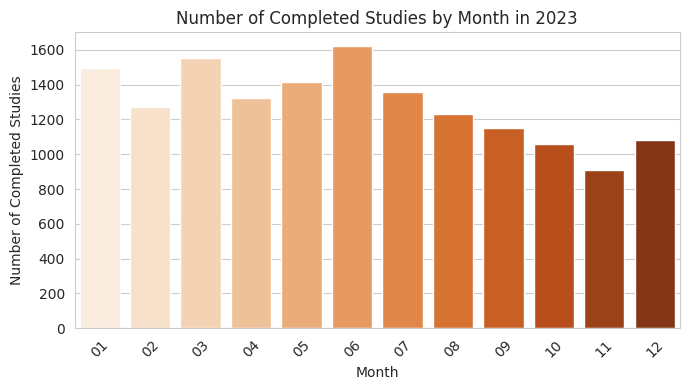

Table of Number of Completed Studies for Each Month in 2023:
Month	Number of Studies Completed
01	1494
02	1272
03	1552
04	1324
05	1415
06	1619
07	1360
08	1230
09	1152
10	1058
11	909
12	1082


In [0]:
monthly_study_count(clinical2023, 2023)

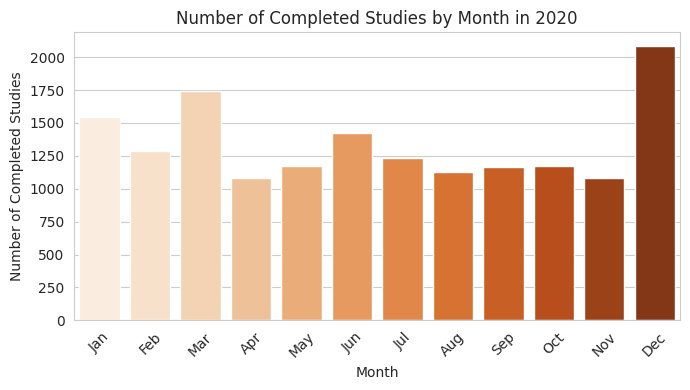

Table of Number of Completed Studies for Each Month in 2020:
Month	Number of Studies Completed
Jan	1544
Feb	1286
Mar	1740
Apr	1080
May	1176
Jun	1424
Jul	1237
Aug	1126
Sep	1167
Oct	1176
Nov	1078
Dec	2084


In [0]:
monthly_study_count(clinical2020, 2020)

In [0]:
data2020=preprocessor()
data2021= preprocessor()
data2023= preprocessor()

kindly enter the file you wish to clean clinicaltrial_2020.csv

kindly enter the file you wish to clean clinicaltrial_2021.csv

kindly enter the file you wish to clean clinicaltrial_2023.csv